# COVID-19 Detection from Clinical Reports of patients

In [6]:
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
from numpy.random import uniform
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout,LeakyReLU
from keras.callbacks import ModelCheckpoint

In [55]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn import model_selection
from sklearn.metrics import accuracy_score, log_loss
import sklearn
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SVMSMOTE, SMOTE
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [189]:
import pickle
import re
import string
import joblib

# Loading, Filtering and Preprocessing Data

In [39]:
df = pd.read_csv("metadata_new.csv",encoding='latin1')

In [40]:
df.head()

,patientid,offset,sex,age,finding,survival,intubated,went_icu,needed_supplemental_O2,extubated,...,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 26
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,0.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,22-Jan-20,"Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,infiltrate in the upper lobe of the left lung,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,3.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,25-Jan-20,"Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,progressive infiltrate and consolidation,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
len(df)

608

In [42]:
#dropping rows with NaN value in clinical reports and finding column

df = df.dropna(subset=['clinical_notes','finding'])

In [43]:
len(df)

298

(array([224.,   4.,  16.,  15.,  17.,   2.,   2.,   4.,  11.,   3.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

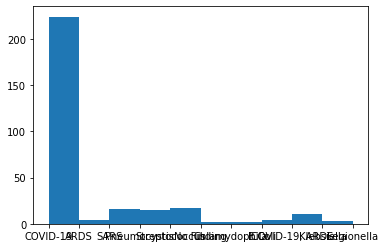

In [44]:
#Analysing the types of epidemics in data
plt.hist(df['finding'])

In [45]:
#Dropping the findings which are less frequrnt and keeping only those with more than 10 frequency

keep_list = ['COVID-19', 'SARS', 'Pneumocystis', 'Streptococcus','COVID-19, ARDS']
df= df[df['finding'].isin(keep_list)]

In [46]:
len(df)

283

(array([224.,   0.,  16.,   0.,   0.,  15.,   0.,  17.,   0.,  11.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

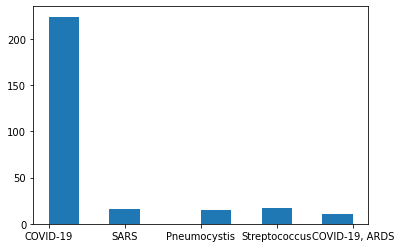

In [47]:
plt.hist(df['finding'])

# Cleaning Data

In [49]:
df['clinical_notes'].tolist()[101]

'Male patient, 87 years old, hospitalized from 02/27 to 01/03/2020 with diagnosis of right heart failure in hypertensive heart disease and PM, regressed with diuretic therapy. At home, unproductive cough without fever. Progressive dyspnea for which he is transported to DEA on 07/03. Apiretic patient, bilateral middle-basal crepitations. Chest x - ray: bilateral middle - basal pulmonary parenchymal thickening, more evident on the right.'

In [191]:
#Removing Date Strings

def rem_date(text_data):
    
    date_rem_list=[]
    for text in text_data:
        t1 = re.sub('(\w*\s\d*\,\s\d*)', '', text)
        t2 = re.sub('(\d*\-\d*\-\d*)', '', t1)
        t3 = re.sub('(\d*\/\d*\/\d*)', '', t2)
        t4 = re.sub('(\d*\,\d*\,\d*)', '', t3)
        t5 = re.sub('(\d*\/\d*)','',t4)
        date_rem_list.append(t5)
    return date_rem_list

In [ ]:
date_rem_list = rem_date(df['clinical_notes'].tolist())

In [52]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [192]:
#Removing punctuations

def rem_punc(text_data):
    string_punctuation= string.punctuation.replace(",","")
    string_punctuation= string_punctuation.replace(".","")
    table = str.maketrans(string_punctuation, ' ' * len(string_punctuation))
    punc_rem_list =[]
    for text in text_data:
        words = word_tokenize(text)
        new_words=[]
        for word in words:
            new_words.append(word if word.replace('.', '', 1).isdigit() else word.translate(table).strip())
        punc_removed = (" ".join(new_words)).lstrip()
        punc_rem_list.append(punc_removed)
    return punc_rem_list

In [ ]:
punc_rem_list = rem_punc(date_rem_list)

In [57]:
punc_rem_list[210]

'In this case , CT images show multiple foci of ground glass opacities involving all pulmonary lobes , some of them associated with fine reticulation , with predominant distribution in the upper and middle lung zones , where part of the opacities are peripheral and other have a peribronchovascular distribution .'

In [58]:
notes_cleaned = punc_rem_list

In [59]:
#Lemmatizing the words to avoid multiple forms of same word

lemmatizer = WordNetLemmatizer()

In [193]:
def word_lem(text_data):
    final_notes = []
    for sent in text_data:
        words = word_tokenize(sent)
        new_words = [lemmatizer.lemmatize(word) for word in words]
        final_notes.append(" ".join(new_words))
    return final_notes

In [ ]:
final_notes = word_lem(notes_cleaned)

In [61]:
final_notes[100]

'73 year old male patient . He enters Mortara s PS for a 10 day fever not responsive to paracetamol . WBC within limit , PCR not available PS radiography at Mortara Hospital fever indication . Feedback of right interstitial paracardial thickening with tendency to cavitation in it most cranial portion.Mild right hilar enlargement.The phlogistic infectious nature is hypothesized .'

# Using Label encoder to convert target column into Sparse labels

In [62]:
le = LabelEncoder()
le.fit(df['finding'])
df['finding'] = le.transform(df['finding'])

In [63]:
classes = le.inverse_transform(df['finding'])
classes_ = np.unique(classes).tolist()

In [64]:
classes_

['COVID-19', 'COVID-19, ARDS', 'Pneumocystis', 'SARS', 'Streptococcus']

In [73]:
y = df['finding'].tolist()

# Converting Text to vectors using TF-IDF

In [68]:
vectorizer = TfidfVectorizer(min_df=2,max_df=0.95,stop_words='english',ngram_range=(1,1))
X = vectorizer.fit_transform(final_notes)

In [69]:
X.shape

(283, 902)

In [70]:
print(vectorizer.get_feature_names())

['10', '100', '109', '11', '12', '13', '135', '14', '15', '150', '16', '17', '178', '19', '20', '200', '2019', '21', '22', '225', '23', '24', '25', '250', '25mmol', '27', '28', '28m', '29', '2a', '2b', '2nd', '30', '36', '36ld', '37', '37mmhg', '38', '38ºc', '39', '40', '420', '43', '44', '46', '47', '50', '52', '53', '60', '63', '65', '67000', '67ld', '69mmhg', '70', '71', '7250', '73', '74', '75', '82', '83', '85', '87', '88', '89', '8g', '90', '92', '93', '95', '96', '97', 'abdomen', 'abdominal', 'abnormality', 'absence', 'absorption', 'accentuation', 'access', 'accompanied', 'acquired', 'acute', 'adenopathy', 'administered', 'admission', 'admitted', 'adult', 'aeration', 'aged', 'agent', 'ago', 'air', 'airspace', 'airway', 'alert', 'alteration', 'alveolar', 'ambient', 'anamnesis', 'angiography', 'angle', 'anterior', 'anteroposterior', 'antibiotic', 'antiviral', 'ap', 'apical', 'apiretic', 'appear', 'appearance', 'appeared', 'appreciated', 'appropriate', 'apr', 'apyretic', 'ards', 'a

# Applying SMOTE Algorithm to balance the dataset

In [123]:
from imblearn.over_sampling import SVMSMOTE, SMOTE

In [124]:
#oversample = SVMSMOTE()

In [165]:
smt = SMOTE(k_neighbors=10)
X_SMOTE, y_SMOTE = smt.fit_sample(X, y)
pd.DataFrame(X_SMOTE.todense(), columns=vectorizer.get_feature_names())

,10,100,109,11,12,13,135,14,15,150,...,work,worse,worsening,worth,wuhan,xay,xr,year,young,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.065771


In [166]:
X_train, X_test, y_train, y_test = train_test_split( X_SMOTE, y_SMOTE, test_size=0.2,shuffle=True)

# Training Classical Machine Learning Models

In [167]:
models_f1 = []
models_f1.append((LogisticRegression()))
#models.append(('GSearch', LinearDiscriminantAnalysis()))
models_f1.append(( KNeighborsClassifier()))
models_f1.append((DecisionTreeClassifier()))
models_f1.append((MultinomialNB()))
models_f1.append((SVC(kernel="linear", C=0.1,probability=True)))
models_f1.append((RandomForestClassifier()))
models_f1.append((AdaBoostClassifier()))

LogisticRegression
****Results****
Accuracy: 99.5536%
****F1 score,Precision and recall****
f1_score: 0.9950587158761628 , Precison: 0.9952380952380953, Recall: 0.9949999999999999, Individual_f1: [0.98734177 1.         1.         1.         0.98795181]
***confusion matrix****


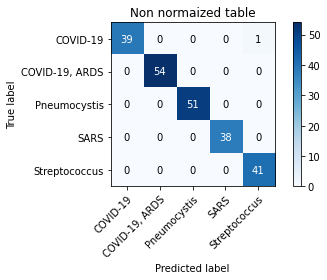

Log Loss: 0.13544484520766678
KNeighborsClassifier
****Results****
Accuracy: 88.3929%
****F1 score,Precision and recall****
f1_score: 0.8519340424303383 , Precison: 0.9032461982461983, Recall: 0.8699999999999999, Individual_f1: [0.51851852 0.90756303 0.95327103 0.92682927 0.95348837]
***confusion matrix****


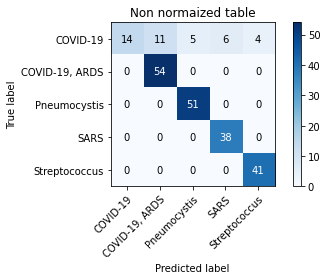

Log Loss: 1.3686732850195078
DecisionTreeClassifier
****Results****
Accuracy: 98.6607%
****F1 score,Precision and recall****
f1_score: 0.9860738561094713 , Precison: 0.9861883214824392, Recall: 0.9860784313725489, Individual_f1: [0.96202532 1.         0.98039216 1.         0.98795181]
***confusion matrix****


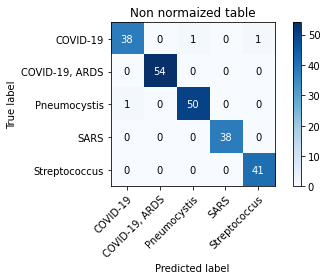

Log Loss: 0.4625728981461297
MultinomialNB
****Results****
Accuracy: 95.5357%
****F1 score,Precision and recall****
f1_score: 0.9497673736227954 , Precison: 0.9581169905896816, Recall: 0.95, Individual_f1: [0.85714286 0.97297297 0.98076923 0.95       0.98795181]
***confusion matrix****


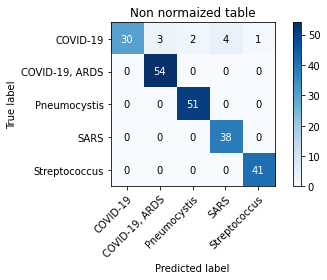

Log Loss: 0.12953959099903942
SVC
****Results****
Accuracy: 100.0000%
****F1 score,Precision and recall****
f1_score: 1.0 , Precison: 1.0, Recall: 1.0, Individual_f1: [1. 1. 1. 1. 1.]
***confusion matrix****


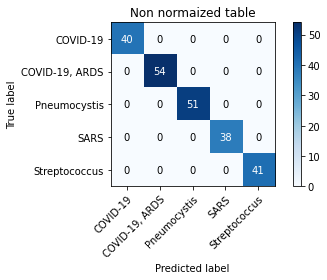

Log Loss: 0.022073931378831395
RandomForestClassifier
****Results****
Accuracy: 100.0000%
****F1 score,Precision and recall****
f1_score: 1.0 , Precison: 1.0, Recall: 1.0, Individual_f1: [1. 1. 1. 1. 1.]
***confusion matrix****


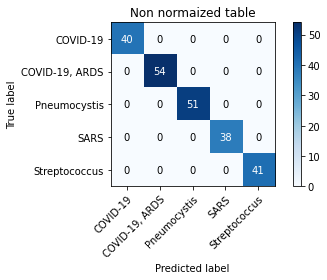

Log Loss: 0.03669363485224687
AdaBoostClassifier
****Results****
Accuracy: 81.2500%
****F1 score,Precision and recall****
f1_score: 0.7451517025543 , Precison: 0.7825, Recall: 0.7943137254901961, Individual_f1: [0.08888889 1.         0.95918367 1.         0.67768595]
***confusion matrix****


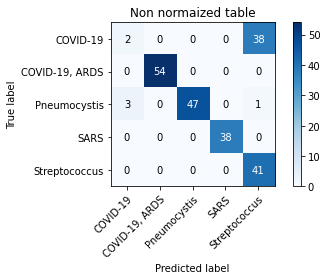

Log Loss: 0.49137385362950736


In [168]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)
for clf in models_f1:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
   
    print("="*30)
    print(name)
   
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
   
    print('****F1 score,Precision and recall****')
    f1_score = sklearn.metrics.f1_score(y_test, train_predictions,average='macro')
    Precision = sklearn.metrics.precision_score(y_test, train_predictions,average='macro')
    Recall = sklearn.metrics.recall_score(y_test, train_predictions,average='macro')
    individual_f1 = sklearn.metrics.f1_score(y_test, train_predictions, average=None)
    print("f1_score: {} , Precison: {}, Recall: {}, Individual_f1: {}".format(f1_score,Precision,Recall,individual_f1))
   
    print('***confusion matrix****')
    classes = classes_
    cm = confusion_matrix(y_test, train_predictions)
    fig, ax = plt.subplots()
    cmap=plt.cm.Blues
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
  
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           
           xticklabels=classes, yticklabels=classes,
           title="Non normaized table",
           ylabel='True label',
           xlabel='Predicted label')

    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    normalize = False
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
   
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
   
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)

# Training a neural network model

In [169]:
mcp = ModelCheckpoint("checkpoint", monitor="val_acc",
                      save_best_only=True, save_weights_only=False)

In [170]:

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')==1.0):
      print("\nReached 100% accuracy so cancelling training!")
      self.model.stop_training = True

In [171]:
cb = myCallback()

In [172]:
X_train.shape

(896, 902)

In [173]:
model = Sequential()
model.add(Dense(64,input_dim=X_train.shape[1], init='uniform'))#,activation = 'LeakyRelu'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(5, activation = 'softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, nb_epoch=100,validation_split=0.2,callbacks=[mcp,cb])

d:\anaconda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, input_dim=902, kernel_initializer="uniform")`
  
d:\anaconda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 716 samples, validate on 180 samples
Epoch 1/100
716/716 [==============================] - 0s 663us/step - loss: 1.4402 - accuracy: 0.7444 - val_loss: 1.2468 - val_accuracy: 0.8556
Epoch 2/100
716/716 [==============================] - 0s 179us/step - loss: 1.0246 - accuracy: 0.9399 - val_loss: 0.8577 - val_accuracy: 0.8889
Epoch 3/100
448/716 [=================>............] - ETA: 0s - loss: 0.7152 - accuracy: 0.9464

d:\anaconda\envs\deeplearning\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


716/716 [==============================] - 0s 167us/step - loss: 0.6525 - accuracy: 0.9637 - val_loss: 0.5628 - val_accuracy: 0.9333
Epoch 4/100
716/716 [==============================] - 0s 184us/step - loss: 0.4045 - accuracy: 0.9860 - val_loss: 0.3754 - val_accuracy: 0.9611
Epoch 5/100
716/716 [==============================] - 0s 160us/step - loss: 0.2545 - accuracy: 0.9958 - val_loss: 0.2575 - val_accuracy: 0.9944
Epoch 6/100
716/716 [==============================] - 0s 158us/step - loss: 0.1677 - accuracy: 0.9986 - val_loss: 0.1833 - val_accuracy: 1.0000
Epoch 7/100
716/716 [==============================] - 0s 165us/step - loss: 0.1159 - accuracy: 0.9986 - val_loss: 0.1390 - val_accuracy: 1.0000
Epoch 8/100
716/716 [==============================] - 0s 223us/step - loss: 0.0838 - accuracy: 1.0000 - val_loss: 0.1099 - val_accuracy: 1.0000

Reached 100% accuracy so cancelling training!


In [174]:
model.evaluate(X_test,y_test)

224/224 [==============================] - 0s 83us/step


[0.1009187740939004, 0.9955357313156128]

In [175]:
y_pred = model.predict_classes(X_test)

In [176]:
y_pred


array([0, 1, 1, 0, 2, 1, 3, 4, 4, 2, 1, 1, 1, 1, 4, 4, 4, 4, 3, 2, 2, 3,
       0, 0, 4, 4, 2, 4, 4, 3, 4, 4, 1, 0, 3, 3, 2, 4, 0, 4, 0, 1, 3, 3,
       2, 2, 1, 2, 3, 3, 1, 0, 3, 2, 1, 2, 0, 2, 1, 2, 0, 3, 1, 1, 1, 2,
       4, 4, 3, 4, 4, 3, 4, 0, 2, 0, 3, 1, 0, 0, 1, 4, 1, 2, 1, 0, 4, 2,
       4, 3, 1, 2, 0, 3, 3, 4, 4, 2, 4, 1, 1, 2, 0, 3, 2, 3, 1, 4, 0, 1,
       1, 1, 2, 3, 3, 2, 4, 4, 4, 2, 0, 1, 4, 4, 2, 0, 0, 2, 4, 0, 2, 0,
       1, 2, 2, 4, 0, 2, 4, 4, 4, 2, 0, 0, 2, 3, 3, 1, 2, 1, 2, 1, 2, 3,
       2, 2, 4, 0, 4, 1, 1, 3, 4, 4, 4, 1, 0, 0, 1, 3, 2, 1, 3, 1, 2, 2,
       0, 0, 0, 3, 4, 3, 2, 3, 2, 3, 3, 2, 3, 0, 0, 3, 0, 0, 1, 0, 3, 2,
       1, 1, 2, 0, 1, 1, 1, 1, 2, 1, 3, 3, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2,
       1, 1, 0, 2], dtype=int64)

In [177]:
np.array(y_test)

array([0, 1, 1, 0, 2, 1, 3, 4, 4, 2, 1, 1, 1, 1, 4, 4, 4, 4, 3, 2, 2, 3,
       0, 0, 4, 4, 2, 4, 4, 3, 4, 4, 1, 0, 3, 3, 2, 4, 0, 4, 0, 1, 3, 3,
       2, 2, 1, 2, 3, 3, 1, 0, 3, 2, 1, 2, 0, 2, 1, 2, 0, 3, 1, 1, 1, 2,
       4, 4, 3, 4, 4, 3, 0, 0, 2, 0, 3, 1, 0, 0, 1, 4, 1, 2, 1, 0, 4, 2,
       4, 3, 1, 2, 0, 3, 3, 4, 4, 2, 4, 1, 1, 2, 0, 3, 2, 3, 1, 4, 0, 1,
       1, 1, 2, 3, 3, 2, 4, 4, 4, 2, 0, 1, 4, 4, 2, 0, 0, 2, 4, 0, 2, 0,
       1, 2, 2, 4, 0, 2, 4, 4, 4, 2, 0, 0, 2, 3, 3, 1, 2, 1, 2, 1, 2, 3,
       2, 2, 4, 0, 4, 1, 1, 3, 4, 4, 4, 1, 0, 0, 1, 3, 2, 1, 3, 1, 2, 2,
       0, 0, 0, 3, 4, 3, 2, 3, 2, 3, 3, 2, 3, 0, 0, 3, 0, 0, 1, 0, 3, 2,
       1, 1, 2, 0, 1, 1, 1, 1, 2, 1, 3, 3, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2,
       1, 1, 0, 2])

In [178]:
classes_

['COVID-19', 'COVID-19, ARDS', 'Pneumocystis', 'SARS', 'Streptococcus']

In [179]:
from sklearn.metrics import classification_report, confusion_matrix,plot_confusion_matrix

****F1 score,Precision and recall****
f1_score: 0.9950587158761628 , Precison: 0.9952380952380953, Recall: 0.9949999999999999, Individual_f1: [0.98734177 1.         1.         1.         0.98795181]
***confusion matrix****


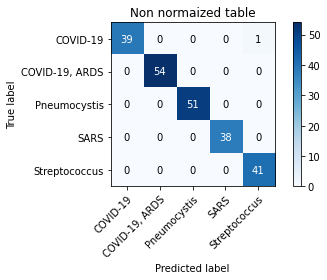

In [180]:
import sklearn 
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline





print('****F1 score,Precision and recall****')
f1_score = sklearn.metrics.f1_score(y_test, y_pred,average='macro')
Precision = sklearn.metrics.precision_score(y_test,y_pred,average='macro')
Recall = sklearn.metrics.recall_score(y_test,y_pred,average='macro')
individual_f1 = sklearn.metrics.f1_score(y_test, y_pred, average=None)
print("f1_score: {} , Precison: {}, Recall: {}, Individual_f1: {}".format(f1_score,Precision,Recall,individual_f1))

print('***confusion matrix****')
classes = classes_
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
cmap=plt.cm.Blues
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),

       xticklabels=classes, yticklabels=classes,
       title="Non normaized table",
       ylabel='True label',
       xlabel='Predicted label')


plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

normalize = False
fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.show()

# Saving and loading the model for inference 

In [190]:
#saving model
model.save("model_nn.h5")

#saving vectors
pickle.dump(vectorizer, open('tfidf_vec.pkl', 'wb'))

In [230]:
#loading saved model and saved vectorizer

import keras
from keras.models import load_model
model_ = tf.keras.models.load_model('model_nn.h5')
tfidf_vectorizer = joblib.load("tfidf_vec.pkl")

In [227]:
#taking a sample SARS clinical report

df['clinical_notes'].iloc[280], classes[df['finding'].iloc[280]]

('Serial radiographic appearances in a 23-year-old woman with SARS, type 1 pattern. Follow-up frontal chest radiograph obtained 5 days later shows progression of radiographic changes, with multifocal bilateral air-space opacities in both lungs.',
 'SARS')

In [238]:
date_remove = rem_date([df['clinical_notes'].iloc[280]])
punc_remove = rem_punc(date_remove)
lem_text = word_lem(punc_remove)

In [239]:
text_vector = tfidf_vectorizer.transform(lem_text)

In [240]:
text_vector.shape

(1, 902)

In [243]:
classes[model.predict_classes(text_vector)[0]]

'SARS'